# Portfólio fronteira eficiente de Markowitz

Olá leitor, hoje iremos abordar um assunto muito falado na área quant, a fronteira eficiente de markowitz. Dividiremos o trabalho em duas partes, neste notebook falaremos sobre a parte matemática, em outro, nos dedicaremos em fazer um backtest e testar a perfomance de uma estratégia aplicando o conceito.

# Teoria

Resumidamente, no modelo de Markowitz queremos maximizar uma função que envolve alguma métrica de risco e retorno. Definiremos o retorno de um portfólio com n ativos como:
$$R = \mu^T w$$

onde $w = [w_1, w_2, \dots, w_n]$ é o vetor de pesos, definido de tal forma que $\sum_{i=1}^n w_i = 1$ e, $\mu = [\mu_1, \mu_2, \dots, \mu_n]$ é o vetor de retorno dos n ativos. Em seguida, definimos a métrica de risco como:

$$w^T \Sigma w$$

onde $\Sigma$ é a matriz de variâncias e covariâncias. Vamos agora gerar um grande número de portfólios com diferentes pesos fixando o risco e o retorno dos ativos teóricos, por fim, iremos avaliar o comportamento do risco vs retorno desses diferentes portfólios.

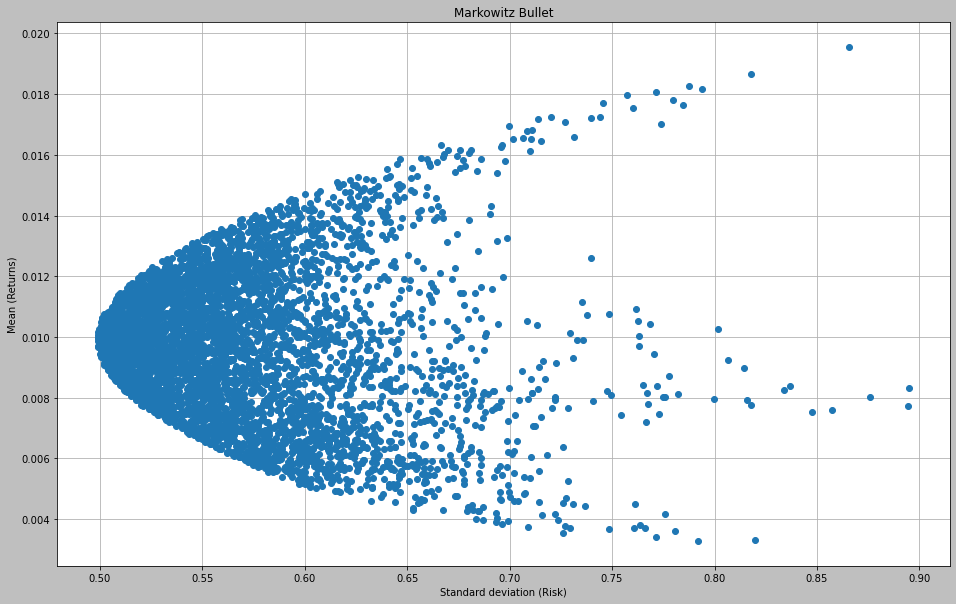

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, LinearConstraint
from yahoo_fin.stock_info import get_data
import datetime as dt

def plot_portfolio(μ, Σ):
    """
    Creation of a markowitz bullet
    """ 
    n = len(Σ)
    PortfolioReturn = []
    PortfolioRisk = []
    for t in range(5000):
        w = np.random.rand(n)
        w /= np.sum(w)
        Risk = np.sqrt(np.dot(w.T, np.dot(Σ,w)))
        Return = np.dot(μ.T, w)
        PortfolioReturn.append(Return)
        PortfolioRisk.append(Risk)
    fig, ax = plt.subplots(figsize=(16,10), facecolor=(0.75, 0.75, 0.75))
    ax.plot(PortfolioRisk, PortfolioReturn, 'o', label='Portfolios')
    plt.xlabel('Standard deviation (Risk)')
    plt.ylabel('Mean (Returns)')
    plt.title('Markowitz Bullet')
    plt.grid()

#Number of assets
n_assets = 4

#Number of observatios (252 days = 1 year)
n_obs = 252*2

returns = np.random.randn(n_assets, n_obs) #Gerar n ativos com n retornos i.i.d.
means = returns.mean(axis=1)
risk = np.cov(returns)
plot_portfolio(means, risk)

Uma curiosidade, a curva acima também é chamada de "Markowitz bullet". Perceba que existe a possibilidade de otimizarmos os pesos em cada ativo por duas funções diferentes, podemos escolher um portfólio que minimize o risco e, selecionar outro que maximize a quantidade de retorno por unidade de risco (sharpe). Iremos aplicar o modelo na prática com o top 10 ativos que compõem o ibovespa atualmente (20/10/2021)

In [2]:
def getPortfolioParameters(S):       
    S0 = S[0]
    X = np.diff(np.log(np.divide(S,S0)), n=1, axis=0)
    μ = X.mean(axis=0)
    Σ = np.cov(X, rowvar=False)

    n = S.shape[1]
    assert n==len(μ)
    assert n==Σ.shape[0] and n==Σ.shape[1]
    return μ, Σ

class portfolio():
    def __init__(self, μ, Σ, premiumRisk=0, minimize_method='std', long_only=True):
        
        n = len(μ)
        
        self.n = n
        self.μ = μ
        self.Σ = Σ
        self.premiumRisk = 0
        self.n_days = 1
        self.minimize_method = minimize_method
        self.premiunRisk = premiumRisk
        self.set_long_only = long_only
    
    def n_bound(self,n):
        return [(0,None) for i in range(n)]
    
    def std(self, w, μ, Σ):
        return (np.dot(w.T, np.dot(Σ, w)))**0.5
    
    def neg_sharpe(self, w, μ, Σ):
        return -(np.dot(w.T,μ))/((np.dot(w.T, np.dot(Σ, w)))**0.5)
    
    
    def optimize(self):
        μ = self.μ
        Σ = self.Σ
        n = self.n
        if self.minimize_method=='std':
            f=self.std
        if self.minimize_method=='neg_sharpe':
            f=self.neg_sharpe
            
        #Initial Guess
        w = np.random.rand(n)
        w /= np.sum(w)
        
        #Model Constraints
        bounds = self.n_bound(n)
        constraints = LinearConstraint(np.ones(n), lb=1, ub=1)
        
        #Optimization
        optimization = minimize(f, w, args=(μ, Σ), 
                        method='SLSQP', 
                        bounds=bounds, constraints=constraints)
                        
        #Risk, Return Calculations
        optW = optimization['x']
        optReturn = (np.dot(optW.T,μ))
        optRisk = (np.dot(optW.T, np.dot(Σ, optW)))**0.5
        
        self.optRisk = optRisk
        self.optReturn = optReturn
        
        return optW, optRisk, optReturn
        
    
    def plot(self):
        #Creation of a markowitz graph representation
        n = self.n
        PortfolioReturn = []
        PortfolioRisk = []
        for t in range(10000):
            ω = np.random.rand(n)
            ω /= np.sum(ω)
            Risk = np.sqrt(np.dot(ω.T, np.dot(self.Σ*(self.n_days),ω)))
            Return = np.dot(ω, ((self.μ+1)**self.n_days)-1)
            PortfolioReturn.append(Return)
            PortfolioRisk.append(Risk)
        fig, ax = plt.subplots(figsize=(16,10), facecolor=(0.75, 0.75, 0.75))
        
        #plot
        ax.plot(PortfolioRisk, PortfolioReturn, 'o', label='Portfolios')
        ax.plot(self.optRisk, self.optReturn, 'bo', label='Optimal Point')
        
        #aesthetics
        ax.set_facecolor((0.1, 0.1, 0.1))
        ax.grid(True)
        ax.set_ylabel('Expected Return')
        ax.set_xlabel('Standard Deviation')
        ax.legend()

ibov = pd.read_csv('IBOVDia_20-10-21.csv', sep=';')
ibov['%'] = ibov['%'].str.replace(',', '.').astype(float)
ibov.sort_values('%', ascending=False, inplace=True)
portfolio_markowitz = ibov['Código'].iloc[:10]

n_obs = 365*4
end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(n_obs)

end_date = end_date.strftime('%d/%m/%Y')
start_date = start_date.strftime('%d/%m/%Y')

S = pd.DataFrame()
for ticker in portfolio_markowitz:
    df = get_data(ticker+'.SA', start_date, end_date, interval = "1wk")
    df = df[['adjclose']]
    df.rename(columns={'adjclose':ticker}, inplace=True)
    S = pd.concat([df, S], axis=1)
S.dropna(inplace=True)

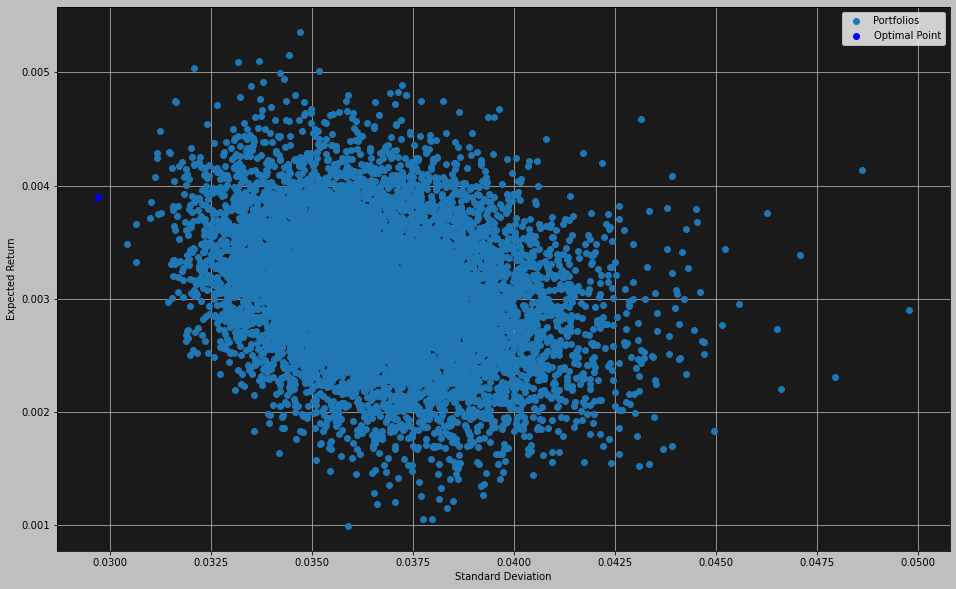

In [3]:
μ, Σ = getPortfolioParameters(S.to_numpy())
opt_portfolio = portfolio(μ, Σ, minimize_method='std')
w, Risk, Return = opt_portfolio.optimize()
opt_portfolio.plot()
opt_w = pd.DataFrame(zip(portfolio_markowitz, w), columns=['Tickers', 'Weights']).round(2)
opt_w = opt_w.loc[opt_w['Weights']>0]

Vale observar que o modelo tende a gerar a "Markowitz bullet" apenas na condição de distribuição normal dos retornos (ou mais genericamente, no caso em que os retornos sejam independentes e igualmente distribuidos)

In [4]:
opt_w #Pesos ótimos de acordo com o modelo de markowitz no dia 20/10/2021

,Tickers,Weights
0,VALE3,0.19
1,PETR4,0.21
2,ITUB4,0.11
3,PETR3,0.22
4,BBDC4,0.04
9,ITSA4,0.23
